# Smooth Local Projections tutorial

This notebook replicates the results of [Barnichon and Brownlees (2019)](https://www3.nd.edu/~nmark/Climate/BarnichonBrownless_ReStat2019.pdf), applying the **Smooth Local Projections** method to estimate the impulse response of GDP to a monetary policy shock.

The approach offers a flexible alternative to traditional VARs by estimating impulse responses directly through local regressions, while imposing smoothness to improve efficiency and interpretability.

In [1]:
import pandas as pd

df = pd.read_csv('../datasets/LP_Data.csv')
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'] + pd.DateOffset(months=2)
df.set_index('date', inplace=True) # this step is super important
df

,yg,pi,ir
date,,,
1959-03-01,9.9779,4.7650,3.0833
1959-06-01,-0.4757,7.1449,3.5767
1959-09-01,1.3967,6.5177,3.9900
1959-12-01,8.8844,1.5806,3.9333
1960-03-01,-1.8741,6.2373,3.6967
...,...,...,...
2006-06-01,0.0525,8.6050,5.2467
2006-09-01,2.7089,-0.2634,5.2467
2006-12-01,0.5426,11.6032,5.2567


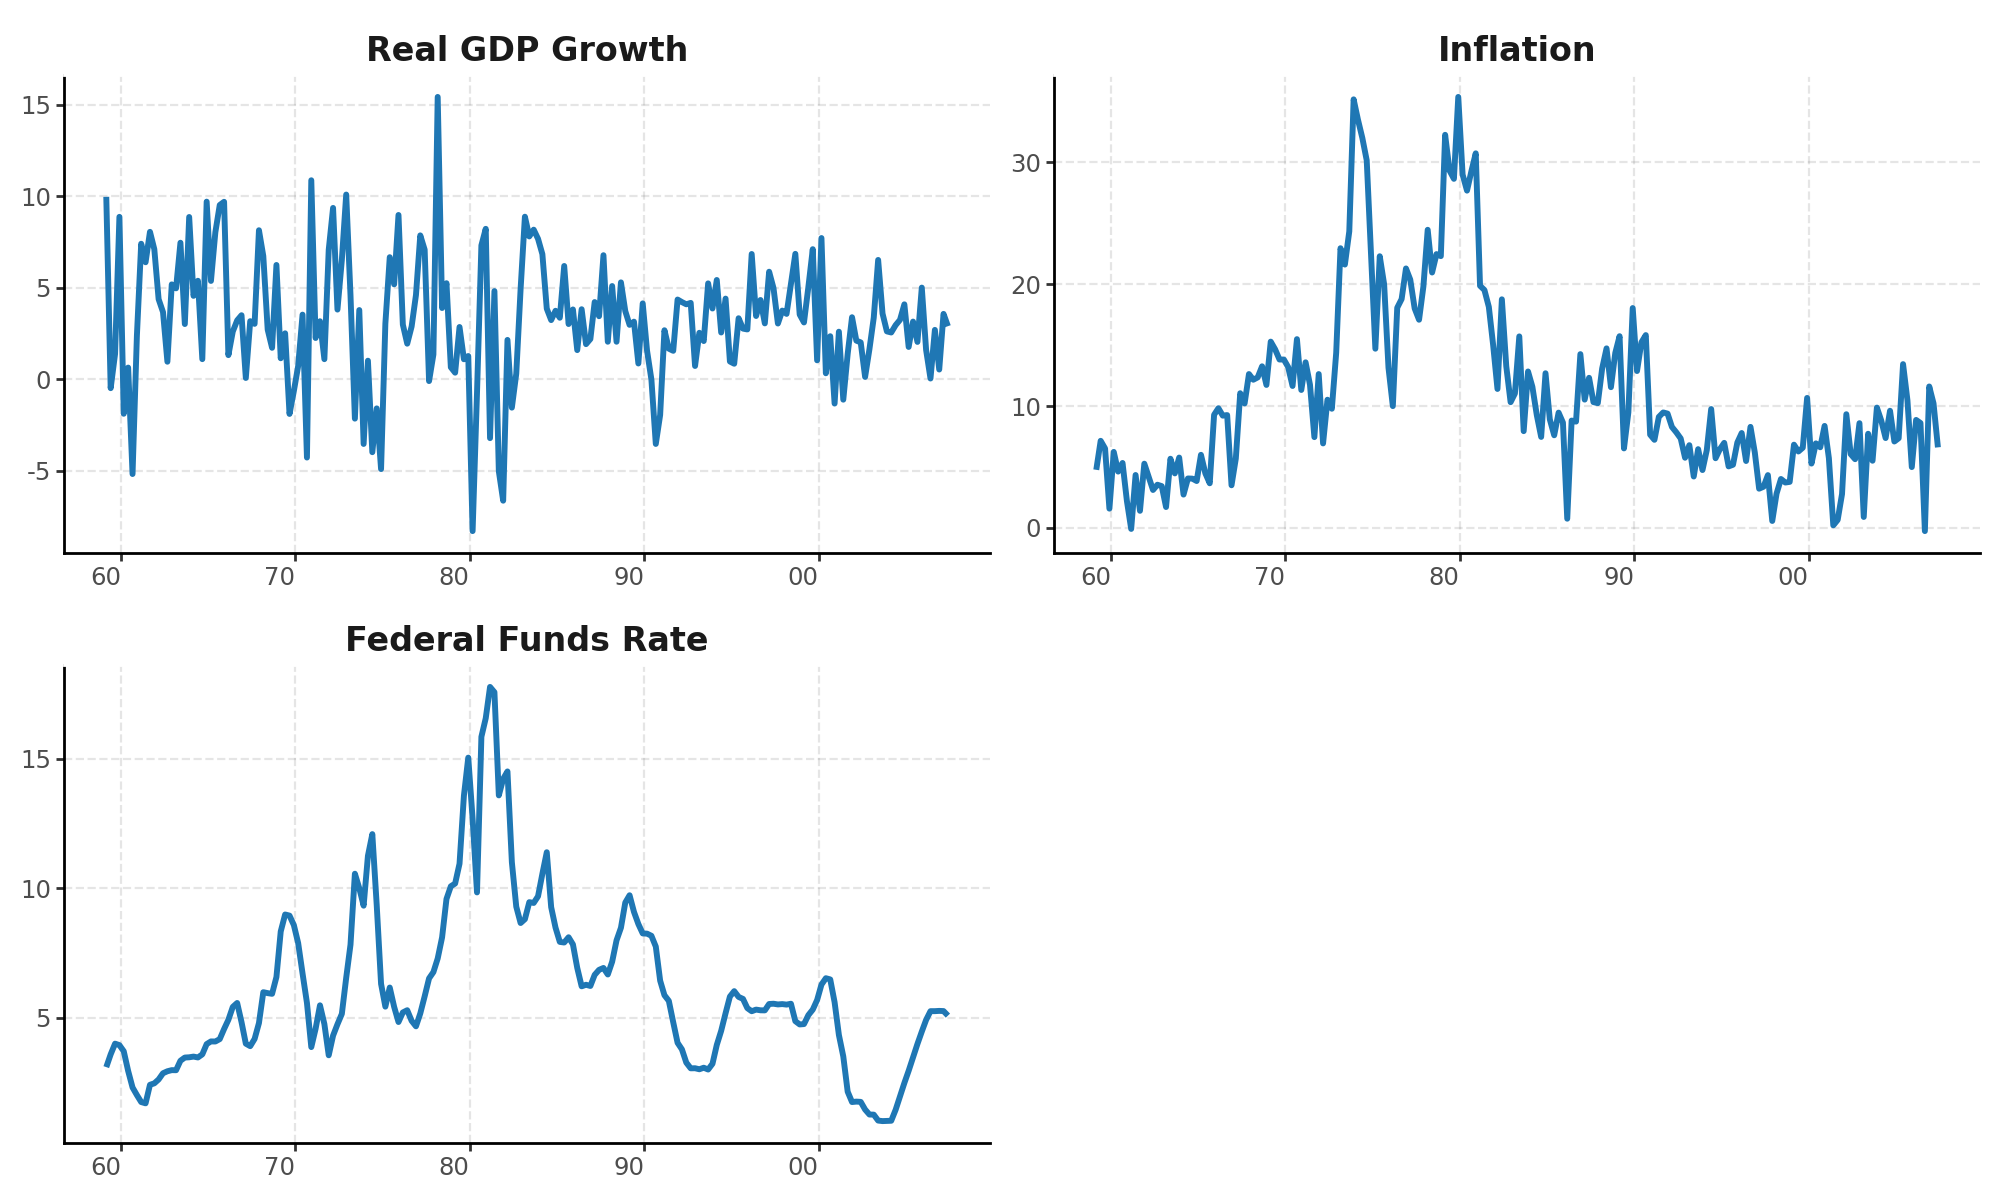

In [2]:
from MacroPy import generate_series_plot

# Generate a series plot for the Stock & Watson (2001) dataset
series_titles = ["Real GDP Growth", "Inflation", "Federal Funds Rate"]
generate_series_plot(df, series_titles=series_titles)

In [3]:
P = 4  # number of lags used in LP
y_col = 'yg'  # response variable
x_col = 'ir'  # shock variable

# Step 1: Contemporaneous controls (first two variables)
contemporaneous = df[['yg', 'pi']].copy()

# Step 2: Create lagged variables for all columns (1 to P lags)
lags = []
for lag in range(1, P + 1):
    lagged = df.shift(lag).copy()
    lagged.columns = [f"{col}_lag{lag}" for col in df.columns]
    lags.append(lagged)

# Step 3: Combine contemporaneous + lags
controls = pd.concat([contemporaneous] + lags, axis=1)

# Step 4: Drop rows with NaNs introduced by lagging
controls_clean = controls.dropna().copy()

# Step 5: Align y and x using the same index as controls_clean
y_clean = df[y_col].loc[controls_clean.index]
x_clean = df[x_col].loc[controls_clean.index]

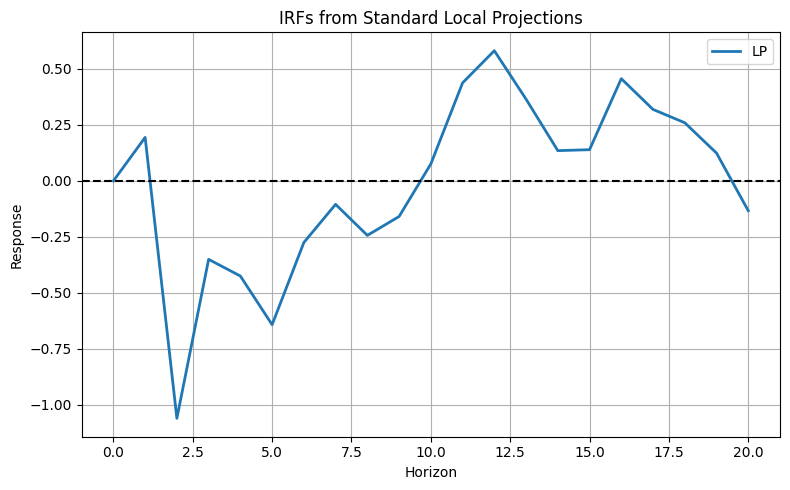

In [4]:
from MacroPy import SmoothLocalProjections as SLP

slp_model = SLP(response=y_clean, shock=x_clean, controls=controls_clean, lags=4, horizons=list(range(1, 21)))
res1 = slp_model.estimate('reg')
SLP.plot_irfs([res1], labels=["LP"], title="IRFs from Standard Local Projections")

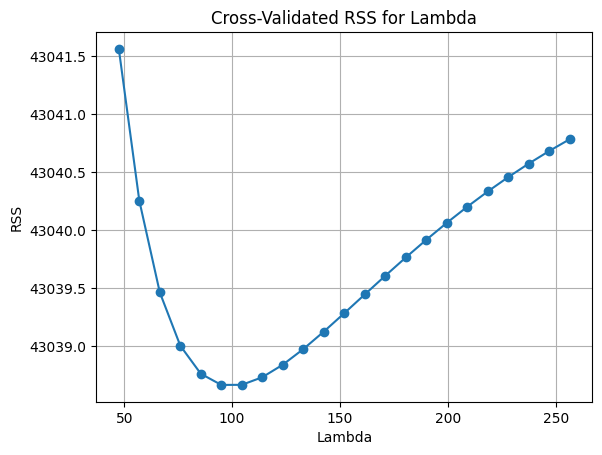

In [5]:
import numpy as np

# Estimate once with small lambda to initialize everything
slp_model.estimate(projection_type='smooth', penalty_order=2, penalty_lambda=0.01)

# Step 2: Cross-validate
lambdas = [i * len(y_clean)/4 for i in np.arange(1, 5.5, 0.2)]
lambda_opt = slp_model.cross_validate_lambda(lambdas)

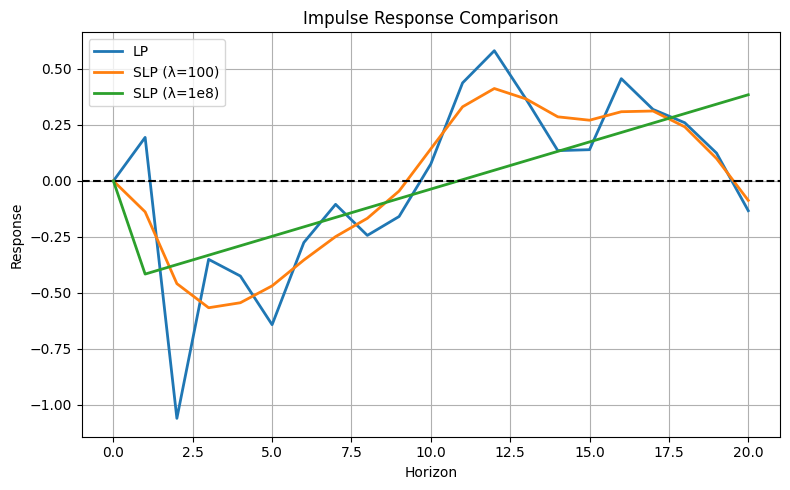

In [6]:
from MacroPy import SmoothLocalProjections as SLP

slp_model = SLP(response=y_clean, shock=x_clean, controls=controls_clean, lags=4, horizons=list(range(1, 21)))

res1 = slp_model.estimate('reg')
res2 = slp_model.estimate('smooth', penalty_lambda=100)
res3 = slp_model.estimate('smooth', penalty_lambda=1e8)

SLP.plot_irfs([res1, res2, res3], labels=["LP", "SLP (λ=100)", "SLP (λ=1e8)"])

## Confidence intervals

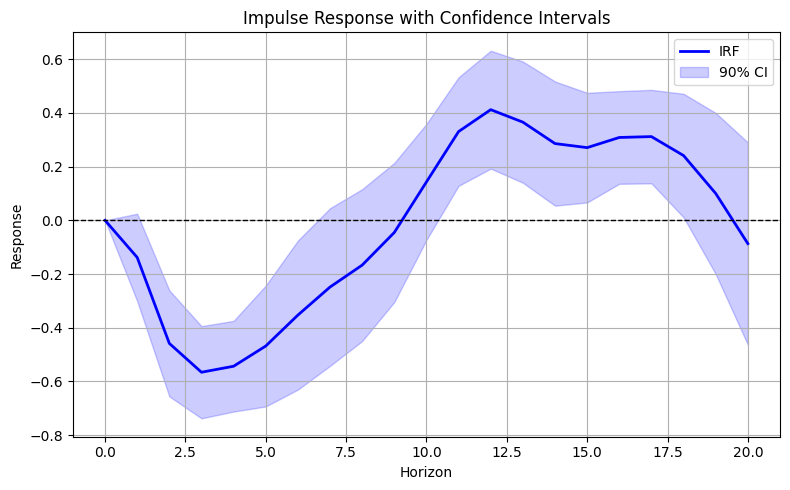

In [7]:
slp_model = SLP(response=y_clean, shock=x_clean, controls=controls_clean, lags=4, horizons=list(range(1, 21)))
res  = slp_model.estimate('smoooth', penalty_lambda=100)
conf = slp_model.compute_confidence_intervals(lag=20)
slp_model.plot_irf_with_confidence()